In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

import tensorflow as tf
from transformers import ViTFeatureExtractor, TFAutoModelForImageClassification
from sklearn.model_selection import train_test_split

In [2]:
mkdir callback

In [3]:
ls

callback/  drive/  sample_data/


In [4]:
callback_dir = '/content/callback'

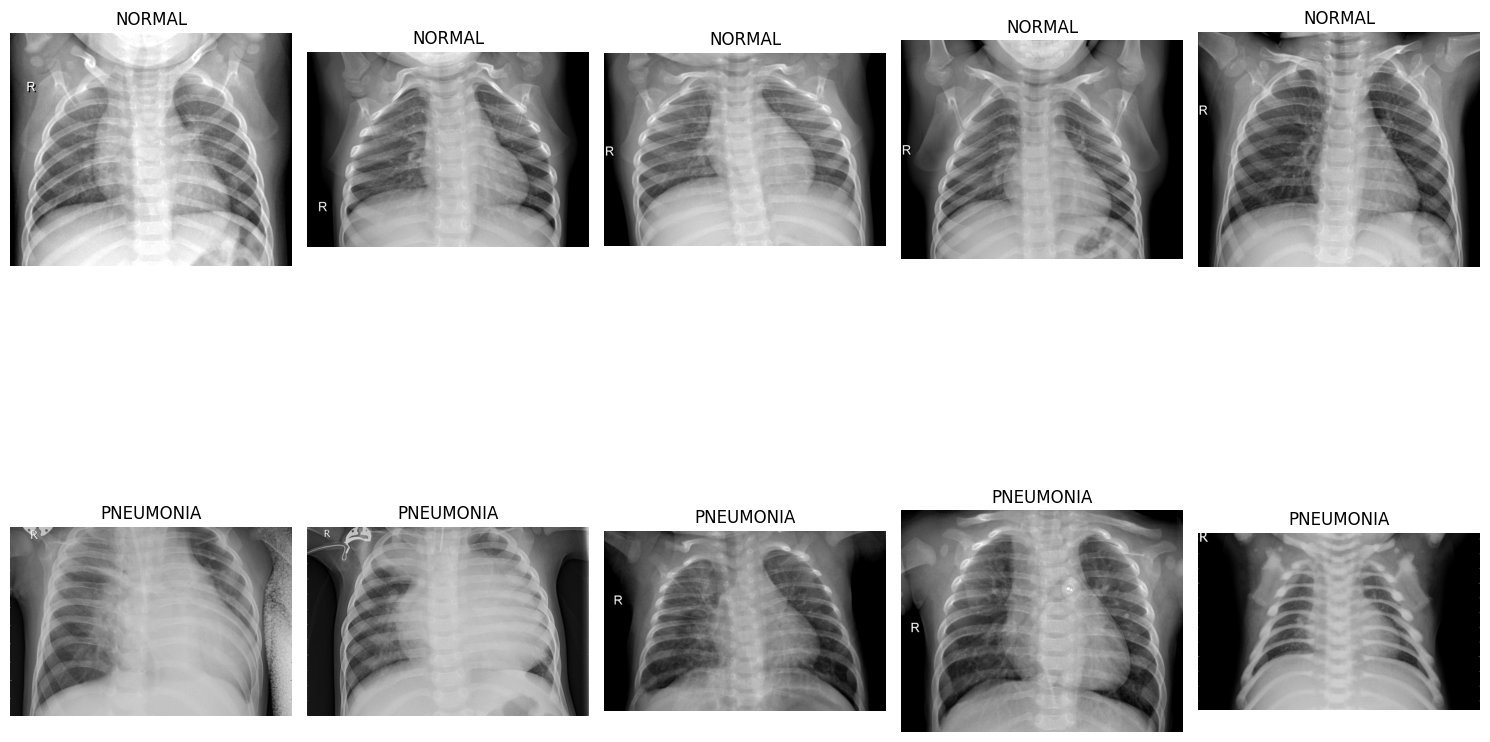

In [11]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from itertools import islice
from tqdm import tqdm


train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

# Directory paths
train_dir_path = Path(train_dir)
val_dir_path = Path(val_dir)
test_dir_path = Path(test_dir)

def display_images(folder, num=5, categories=['NORMAL', 'PNEUMONIA'], cmap='gray'):
    """
    Displays a set of images from specified categories within a folder.

    Parameters:
    - folder (Path): The directory path of the images.
    - num (int): Number of images to display from each category.
    - categories (list): List of categories to display.
    - cmap (str): Color map for displaying images.
    """
    fig, axes = plt.subplots(nrows=len(categories), ncols=num, figsize=(15, 6 * len(categories)))

    for row, category in enumerate(categories):
        img_paths = islice(folder.glob(f'{category}/*.jpeg'), num)
        img_paths = list(tqdm(img_paths, desc=f"Loading {category} images", leave=False))
        for col, img_path in enumerate(img_paths):
            try:
                img = Image.open(img_path)
                axes[row, col].imshow(img, cmap=cmap)
                axes[row, col].set_title(category)
                axes[row, col].axis('off')
            except IOError:
                print(f"Error: Cannot open {img_path}")

    plt.tight_layout()
    plt.show()

display_images(train_dir_path)

In [7]:
label_mapping = {"NORMAL": 0, "PNEUMONIA": 1}

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

import torch

print(f"cuda is_available: {torch.cuda.is_available()}")

cuda is_available: True


In [8]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 19.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

## Introduction

This report describes the training and evaluation of a deep learning model developed to classify chest X-ray images into two categories: normal and pneumonia. The model utilizes the ConvNeXt architecture, specifically the `convnext_tiny` variant, renowned for its effectiveness in image classification tasks due to its efficiency and robustness.

## Model architecture

The model employed in this study is based on the ConvNeXt architecture, which adapts Transformer principles specifically for efficient performance in vision tasks. Unlike traditional Convolutional Neural Networks (CNNs), ConvNeXt simplifies the convolutional design but integrates learnings from Transformers, offering a significant improvement in handling various image recognition tasks.

### Features of ConvNeXt:

- **Layer normalization**: positioned right after each convolution, enhancing training stability.
- **GELU activation**: used instead of ReLU, providing non-linear capabilities that help model complex functions.
- **Depthwise convolution**: reduces computational complexity while maintaining the network's ability to learn high-level features.

## Data processing

### Preprocessing techniques:

1. **Normalization**: standardizes pixel values across images, improving model convergence during training. the normalization parameters are tailored to align with pre-established models trained on the ImageNet dataset.
2. **Data augmentation**: includes random horizontal flipping and rotations up to 10 degrees. These augmentations are crucial for training robust models as they simulate variations in real-world imaging conditions.

### Data loading:

Data is structured into training, validation, and testing sets using the `ImageFolder` class, which facilitates the organization and preprocessing of image data stored in a directory tree. Data loaders shuffle the training data to prevent the model from learning the order of the dataset, which can be crucial for generalizing well on unseen data.

## Training dynamics

### Optimization:

The model is optimized using the Adam optimizer, a method known for its efficiency in handling sparse gradients and adapting the learning rate for each parameter. This choice is particularly effective for training deep neural networks on large datasets.

### Loss function:

The Cross-Entropy Loss function is utilized to quantify the difference between the predicted probabilities and the actual categorical labels. Mathematically, it is expressed as:

\[ \text{Loss} = -\sum_{c=1}^{M} y_{o,c} \log(p_{o,c}) \]

where \( y \) is a binary indicator (0 or 1) if class label \( c \) is the correct classification for observation \( o \), and \( p \) is the predicted probability that observation \( o \) is of class \( c \).

### Model evaluation:

Model performance is regularly evaluated on a validation set during training. This step is critical to monitor and prevent overfitting, ensuring the model's ability to generalize to new, unseen data.

## Model saving strategy

The model is saved conditionally based on its performance on the validation set:

- **Accuracy**: Determines the model's ability to correctly predict the label of the X-ray images.
- **Loss**: Reflects how well the model's predictions align with the actual labels.

Saving the model with the highest accuracy and the lowest loss ensures that the most effective version of the model is retained, striking a balance between precision and robustness.

## Conclusion

In summary, this model training framework leverages advanced architectural features and training techniques to effectively classify medical images. Through meticulous preprocessing, strategic model checkpoints, and continuous performance evaluation, the model is refined to achieve high accuracy and generalization in detecting pneumonia from chest X-ray images.


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import os
import timm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CALLBACK_DIR = '/content/callback'
BEST_MODEL_PATH = f'{CALLBACK_DIR}/best_model.pth'

# data transformations
def get_transforms():
    train_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return train_transforms, val_test_transforms

# DataLoader setup
def get_dataloaders(train_dir, val_dir, test_dir, batch_size=32):
    train_transforms, val_test_transforms = get_transforms()
    train_dataset = ImageFolder(train_dir, transform=train_transforms)
    val_dataset = ImageFolder(val_dir, transform=val_test_transforms)
    test_dataset = ImageFolder(test_dir, transform=val_test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def initialize_model():
    model = timm.create_model('convnext_tiny', pretrained=True, num_classes=2)
    model.to(DEVICE)
    return model

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate_model(model, loader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

def train(model, train_loader, val_loader, optimizer, criterion, device, epochs, save_path):
    best_accuracy = 0
    for epoch in range(epochs):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        accuracy = validate_model(model, val_loader, device)
        if accuracy >= best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), save_path)
            print(f"Epoch {epoch+1}: New best model saved with accuracy: {accuracy:.4f}")
        print(f"Epoch {epoch+1}: loss = {train_loss:.4f}, accuracy = {accuracy:.4f}")


train_dir = '/content/drive/MyDrive/chest_xray/train'
val_dir = '/content/drive/MyDrive/chest_xray/val'
test_dir = '/content/drive/MyDrive/chest_xray/test'

best_model_save_path = f'{callback_dir}/best_model.pth'

train_loader, val_loader, test_loader = get_dataloaders(train_dir, val_dir, test_dir)
model = initialize_model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)
train(model, train_loader, val_loader, optimizer, criterion, DEVICE, 10, best_model_save_path)


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: New best model saved with accuracy: 0.8750
Epoch 1: loss = 0.1202, accuracy = 0.8750


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2: New best model saved with accuracy: 0.9375
Epoch 2: loss = 0.0544, accuracy = 0.9375


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3: New best model saved with accuracy: 1.0000
Epoch 3: loss = 0.0384, accuracy = 1.0000


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4: New best model saved with accuracy: 1.0000
Epoch 4: loss = 0.0283, accuracy = 1.0000


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5: New best model saved with accuracy: 1.0000
Epoch 5: loss = 0.0207, accuracy = 1.0000


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6: loss = 0.0170, accuracy = 0.6250


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7: loss = 0.0131, accuracy = 0.9375


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8: loss = 0.0116, accuracy = 0.6875


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9: New best model saved with accuracy: 1.0000
Epoch 9: loss = 0.0178, accuracy = 1.0000


Training:   0%|          | 0/164 [00:00<?, ?it/s]

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10: New best model saved with accuracy: 1.0000
Epoch 10: loss = 0.0066, accuracy = 1.0000


In [26]:
model.eval()  # set the model to evaluation mode
model.load_state_dict(torch.load(best_model_save_path))

<All keys matched successfully>

In [27]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 0.9166666666666666
Precision: 0.884090909090909
Recall: 0.9974358974358974
F1 Score: 0.9373493975903614
Confusion Matrix:
[[183  51]
 [  1 389]]
